# Checking out George's annotatoins for song vs. not-song segments

In [3]:
import numpy as np

def print_npz_contents(npz_path: str):
    with np.load(npz_path, allow_pickle=True) as archive:
        keys = archive.files
        print(f"Found {len(keys)} item(s) in '{npz_path}':\n")
        for key in keys:
            print(f"--- {key} ---")
            print(archive[key], "\n")

# now simply do:
npz_path = "/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/train/llb3_0010_2018_04_23_15_03_45_segment_0.npz"
print_npz_contents(npz_path)


Found 4 item(s) in '/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/train/llb3_0010_2018_04_23_15_03_45_segment_0.npz':

--- s ---
[[-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 ...
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]] 

--- vocalization ---
[1 1 1 ... 1 1 1] 

--- labels ---
[0 0 0 ... 0 0 0] 

--- song ---
[0 0 0 ... 0 0 0] 



In [7]:
import numpy as np

def print_npz_uniques(npz_path: str):
    """
    Load a .npz archive and for each stored array, print its name,
    its shape, the number of unique values, and the unique values themselves.
    """
    with np.load(npz_path, allow_pickle=True) as archive:
        for key in archive.files:
            arr = archive[key]
            uniques = np.unique(arr)
            print(f"--- {key} ---")
            print(f"shape: {arr.shape}")
            print(f"{uniques.size} unique value(s):")
            print(uniques)
            print()  # blank line

# Example usage:
npz_path = "/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/train/llb3_0010_2018_04_23_15_03_45_segment_0.npz"
print_npz_uniques(npz_path)


--- s ---
shape: (513, 7242)
1050556 unique value(s):
[-80.         -79.99998695 -79.99995055 ...  -0.27609419  -0.24555431
   0.        ]

--- vocalization ---
shape: (7242,)
1 unique value(s):
[1]

--- labels ---
shape: (7242,)
1 unique value(s):
[0]

--- song ---
shape: (7242,)
2 unique value(s):
[0 1]



### Let's see what the spectrogram looks like:

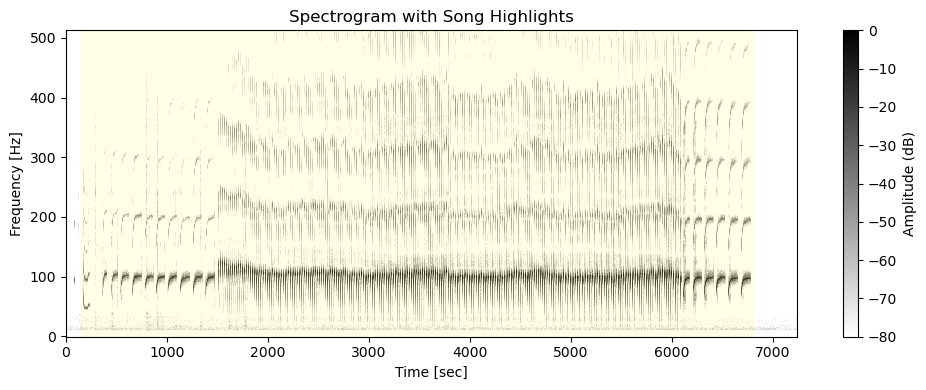

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrogram_with_song_highlight(npz_path: str):
    """
    Load a .npz file containing:
      - 's': spectrogram amplitude (shape: [n_freqs, n_times])
      - 'f': optional frequency bins
      - 't': optional time bins
      - 'songs': binary mask (0/1) for song presence per time bin
    and plot the spectrogram with yellow highlighted song segments,
    using the 'binary' colormap.
    """
    # Load data
    with np.load(npz_path, allow_pickle=True) as data:
        s = data['s']
        f = data['f'] if 'f' in data.files else np.arange(s.shape[0])
        t = data['t'] if 't' in data.files else np.arange(s.shape[1])
        songs = data['song'].astype(bool)

    # Detect contiguous song intervals
    padded = np.concatenate(([False], songs, [False]))
    diff = np.diff(padded.astype(int))
    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]

    # Plot spectrogram with 'binary' colormap
    plt.figure(figsize=(10, 4))
    mesh = plt.pcolormesh(t, f, s, shading='auto', cmap='binary')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Spectrogram with Song Highlights')
    cbar = plt.colorbar(mesh)
    cbar.set_label('Amplitude (dB)' if s.dtype.kind == 'f' else 'Power')

    # Overlay song segments
    for start, end in zip(starts, ends):
        plt.axvspan(t[start], t[end-1], color='yellow', alpha=0.1)

    plt.tight_layout()
    plt.show()

# Example usage:
npz_path = "/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/train/llb3_0010_2018_04_23_15_03_45_segment_0.npz"
plot_spectrogram_with_song_highlight(npz_path)



# Calculate the periodicity for the recording:

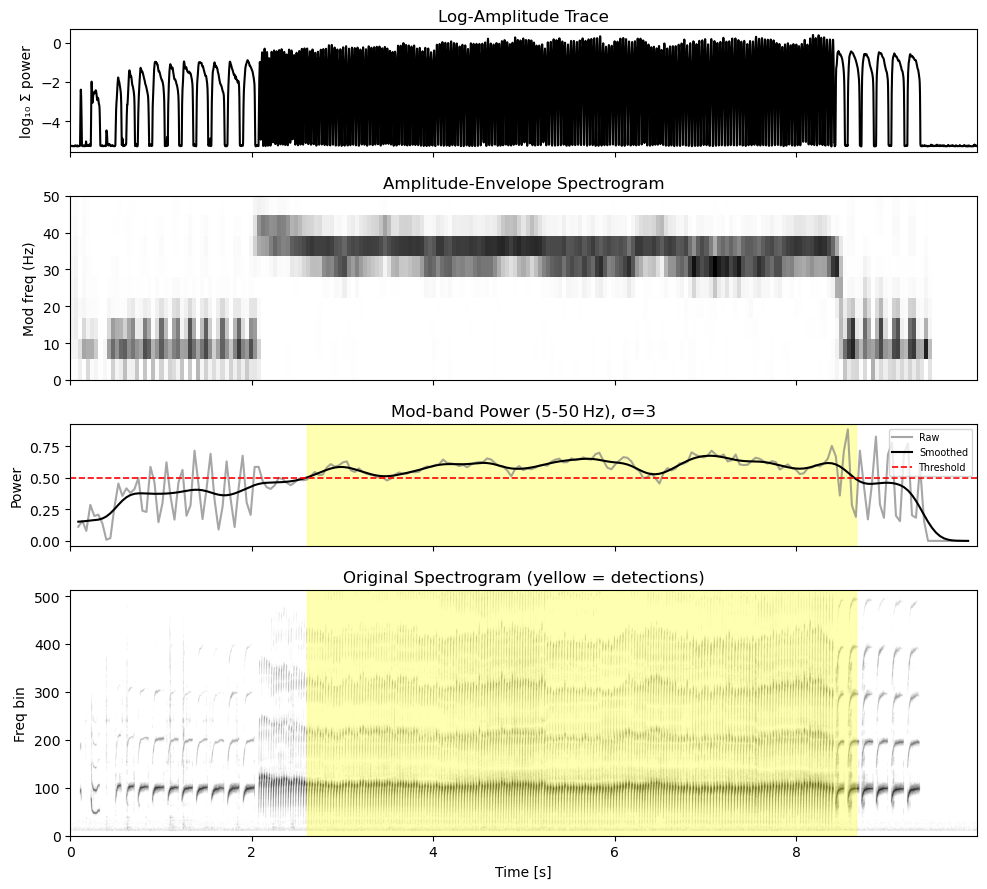

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.ndimage import gaussian_filter1d

# ---------------------------------------------------------------------
# CONFIG – tweak these as desired
# ---------------------------------------------------------------------
FILE_PATH = "/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/train/llb3_0010_2018_04_23_15_03_45_segment_0.npz"

segment_duration = 10          # seconds the original pipeline used per segment
mod_low, mod_high = 5, 50      # modulation‑frequency band (Hz)
smoothing_sigma = 3            # σ for Gaussian smoothing of the power trace
power_threshold = 0.5          # detection threshold (arbitrary units)

# ---------------------------------------------------------------------
# Load the pre‑computed spectrogram
# ---------------------------------------------------------------------
with np.load(FILE_PATH, allow_pickle=True) as npz:
    S_db = npz["s"]          # pre‑computed spectrogram in dB (shape: [freq, time])

# We do not have explicit frequency/time vectors; reconstruct a *relative* axis.
n_freqs, n_times = S_db.shape
time_axis = np.linspace(0, segment_duration, n_times, endpoint=False)
freq_axis = np.arange(n_freqs)               # “bin index” – no absolute Hz available

# Convert dB → linear power, then build a log‑amplitude trace
S_lin   = 10 ** (S_db / 10)
eps     = np.finfo(float).eps
log_amp = np.log10(S_lin.sum(axis=0) + eps)

# ---------------------------------------------------------------------
# Envelope‑spectrogram of the amplitude trace
# ---------------------------------------------------------------------
amp_fs = len(time_axis) / segment_duration   # samples / second for the amplitude trace
nper   = 128
nover  = 96
f_env, t_env, S_env = spectrogram(
    log_amp,
    fs=amp_fs,
    window="hann",
    nperseg=nper,
    noverlap=nover,
)

# Modulation‑band raw & smoothed power
mod_mask   = (f_env >= mod_low) & (f_env <= mod_high)
raw_power  = S_env[mod_mask, :].sum(axis=0)
smooth_pow = gaussian_filter1d(raw_power, sigma=smoothing_sigma)

# ---------------------------------------------------------------------
# Plotting – stack four synced panels
# ---------------------------------------------------------------------
fig, axs = plt.subplots(
    4, 1, figsize=(10, 9), sharex=True,
    gridspec_kw=dict(height_ratios=[1, 1.5, 1, 2])
)

# 1) Log‑amplitude trace
axs[0].plot(time_axis, log_amp, color="black")
axs[0].set_ylabel("log₁₀ Σ power")
axs[0].set_title("Log‑Amplitude Trace")

# 2) Envelope‑spectrogram of the trace
im1 = axs[1].imshow(
    S_env,
    origin="lower",
    aspect="auto",
    extent=[time_axis[0], time_axis[-1], f_env[0], f_env[-1]],
    cmap="binary",
)
axs[1].set_ylim(0, mod_high)
axs[1].set_ylabel("Mod freq (Hz)")
axs[1].set_title("Amplitude‑Envelope Spectrogram")

# 3) Raw & smoothed modulation‑band power
axs[2].plot(t_env, raw_power,   color="grey",  alpha=0.7, label="Raw")
axs[2].plot(t_env, smooth_pow,  color="black",            label="Smoothed")
axs[2].axhline(power_threshold, color="red", ls="--", lw=1.2, label="Threshold")
axs[2].set_ylabel("Power")
axs[2].set_title(
    f"Mod‑band Power ({mod_low}-{mod_high} Hz), σ={smoothing_sigma}"
)

# Highlight detections
detect = smooth_pow > power_threshold
in_span = False
for idx, flag in enumerate(detect):
    if flag and not in_span:
        in_span, t_start = True, t_env[idx]
    elif not flag and in_span:
        for ax in (axs[2], axs[3]):
            ax.axvspan(t_start, t_env[idx], color="yellow", alpha=0.3)
        in_span = False
if in_span:
    for ax in (axs[2], axs[3]):
        ax.axvspan(t_start, time_axis[-1], color="yellow", alpha=0.3)

axs[2].legend(fontsize="x-small", loc="upper right")

# 4) Original spectrogram (normalised 0–1 just for display)
S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + eps)
im2 = axs[3].imshow(
    S_norm,
    origin="lower",
    aspect="auto",
    extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]],
    cmap="binary",
)
axs[3].set_ylabel("Freq bin")
axs[3].set_xlabel("Time [s]")
axs[3].set_title("Original Spectrogram (yellow = detections)")

plt.tight_layout()
plt.show()


# Now, the amplitude song detector:

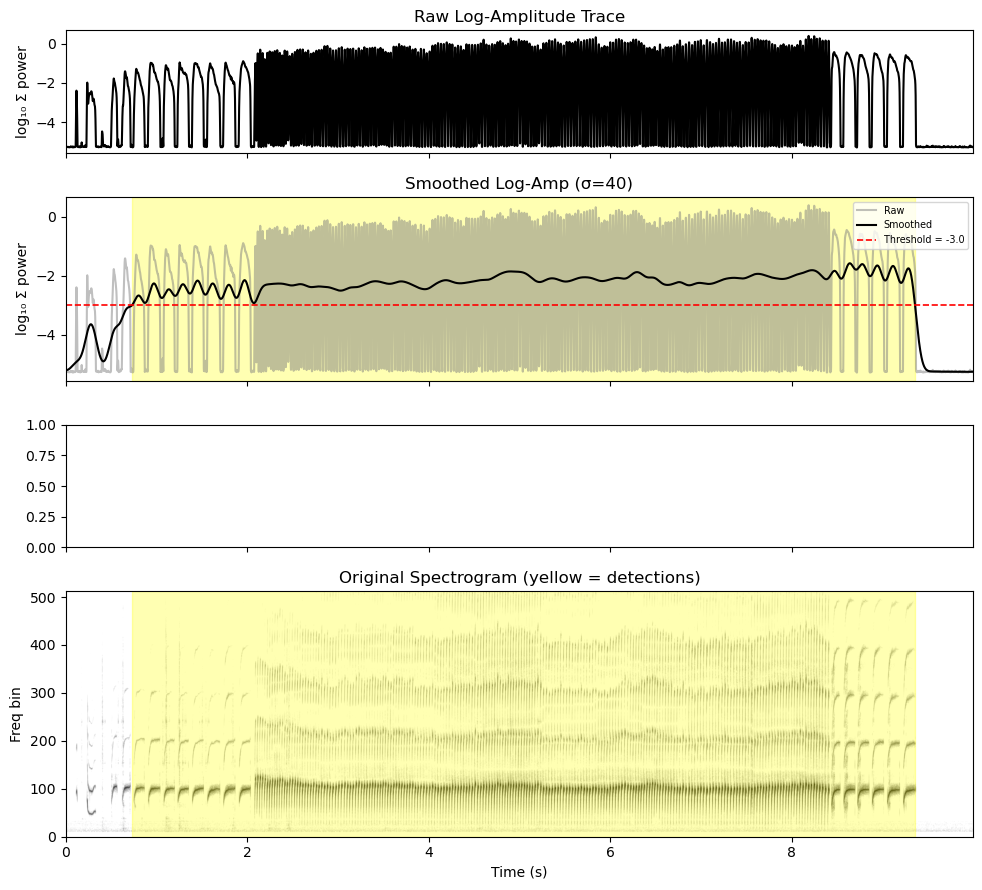


Detected intervals (s):
    0.729 –   9.361


In [ ]:
#!/usr/bin/env python
# -*- coding: utf‑8 -*-

"""
Visualise a spectrogram stored in an .npz file and detect song by applying
smoothing + threshold directly to the log‑amplitude trace.

Required .npz keys
    s : 2‑D ndarray  (freq × time)           spectrogram values
Optional keys
    f : 1‑D ndarray  frequency axis (Hz)
    t : 1‑D ndarray  time axis (s)

If 't' is missing, supply `segment_duration` so the code can build a time axis.
"""

from pathlib import Path
from typing import Union, List, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.ndimage import gaussian_filter1d

# ── helper: build intervals from a boolean mask ─────────────────────────────
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray) -> List[Tuple[float, float]]:
    spans: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, flag in enumerate(mask):
        if flag and not in_run:
            in_run, start = True, times[idx]
        elif not flag and in_run:
            spans.append((start, times[idx]));  in_run = False
    if in_run:
        spans.append((start, times[-1]))
    return spans

# ── main routine ────────────────────────────────────────────────────────────
def plot_npz_logamp_panels(
        npz_path: Union[str, Path],
        segment_duration: Optional[float] = None,  # deduced from 't' if present
        smoothing_sigma: float = 3,
        log_threshold: float = -1.0,
        mod_low: float = 5,
        mod_high: float = 50,
    ) -> List[Tuple[float, float]]:
    """Generate 4 synced panels and return detected (start, end) intervals."""
    npz_path = Path(npz_path).expanduser()
    if npz_path.suffix.lower() != ".npz":
        raise ValueError("Only .npz files are supported.")

    # ── load data ──────────────────────────────────────────────────────────
    with np.load(npz_path, allow_pickle=True) as npz:
        S_raw = npz["s"]
        f = npz["f"] if "f" in npz.files else np.arange(S_raw.shape[0])
        t = npz["t"] if "t" in npz.files else None

    # Derive / validate time axis
    if t is None:
        if segment_duration is None:
            raise ValueError("Provide segment_duration if 't' axis is absent.")
        n_times = S_raw.shape[1]
        t = np.linspace(0, segment_duration, n_times, endpoint=False)
    else:
        if segment_duration is None:
            segment_duration = t[-1] + (t[1] - t[0])

    # Convert dB → linear if needed
    eps = np.finfo(float).eps
    S_lin = 10 ** (S_raw / 10) if np.any(S_raw < 0) else S_raw

    # ── log‑amplitude trace & smoothing ───────────────────────────────────
    log_amp    = np.log10(S_lin.sum(axis=0) + eps)
    log_amp_sm = gaussian_filter1d(log_amp, sigma=smoothing_sigma)
    detections = log_amp_sm > log_threshold
    det_intervals = mask_to_intervals(detections, t)

    # ── envelope spectrogram of log‑amp (context only) ────────────────────
    amp_fs = len(t) / segment_duration
    f_env, t_env, S_env = spectrogram(
        log_amp, fs=amp_fs, window="hann", nperseg=128, noverlap=96
    )

    # ── plotting ──────────────────────────────────────────────────────────
    fig, axs = plt.subplots(
        4, 1, figsize=(10, 9), sharex=True,
        gridspec_kw=dict(height_ratios=[1, 1.5, 1, 2])
    )

    # 1) raw log‑amp
    axs[0].plot(t, log_amp, color="black")
    axs[0].set_ylabel("log₁₀ Σ power")
    axs[0].set_title("Raw Log‑Amplitude Trace")

    # 2) smoothed log‑amp with threshold
    axs[1].plot(t, log_amp,    color="grey", alpha=0.5, label="Raw")
    axs[1].plot(t, log_amp_sm, color="black",            label="Smoothed")
    axs[1].axhline(log_threshold, color="red", ls="--", lw=1.2,
                   label=f"Threshold = {log_threshold}")
    for s_int, e_int in det_intervals:
        axs[1].axvspan(s_int, e_int, color="yellow", alpha=0.3)
    axs[1].set_ylabel("log₁₀ Σ power")
    axs[1].set_title(f"Smoothed Log‑Amp (σ={smoothing_sigma})")
    axs[1].legend(fontsize="x-small", loc="upper right")

    # 3) amplitude‑envelope spectrogram
    axs[2].imshow(
        S_env, origin="lower", aspect="auto",
        extent=[t[0], t[-1], f_env[0], f_env[-1]],
        cmap="binary"
    )
    axs[2].set_ylim(0, mod_high)
    axs[2].set_ylabel("Mod freq (Hz)")
    axs[2].set_title("Envelope Spectrogram (context)")

    # 4) original spectrogram
    S_norm = (S_raw - S_raw.min()) / (S_raw.max() - S_raw.min() + eps)
    axs[3].imshow(
        S_norm, origin="lower", aspect="auto",
        extent=[t[0], t[-1], f[0], f[-1]],
        cmap="binary"
    )
    for s_int, e_int in det_intervals:
        axs[3].axvspan(s_int, e_int, color="yellow", alpha=0.3)
    axs[3].set_ylabel("Freq bin")
    axs[3].set_xlabel("Time (s)")
    axs[3].set_title("Original Spectrogram (yellow = detections)")

    plt.tight_layout()
    plt.show()

    # console report
    if det_intervals:
        print("\nDetected intervals (s):")
        for s_int, e_int in det_intervals:
            print(f"  {s_int:7.3f} – {e_int:7.3f}")
    else:
        print("\nNo detections above threshold.")
    return det_intervals

# ── example call ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    plot_npz_logamp_panels(
        "/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/train/llb3_0010_2018_04_23_15_03_45_segment_0.npz",
        segment_duration=10,     # supply if 't' axis missing in file
        smoothing_sigma=40,       # Gaussian σ (samples)
        log_threshold=-3.0,      # dB value after smoothing
        mod_low=5, mod_high=50   # envelope plot context
    )


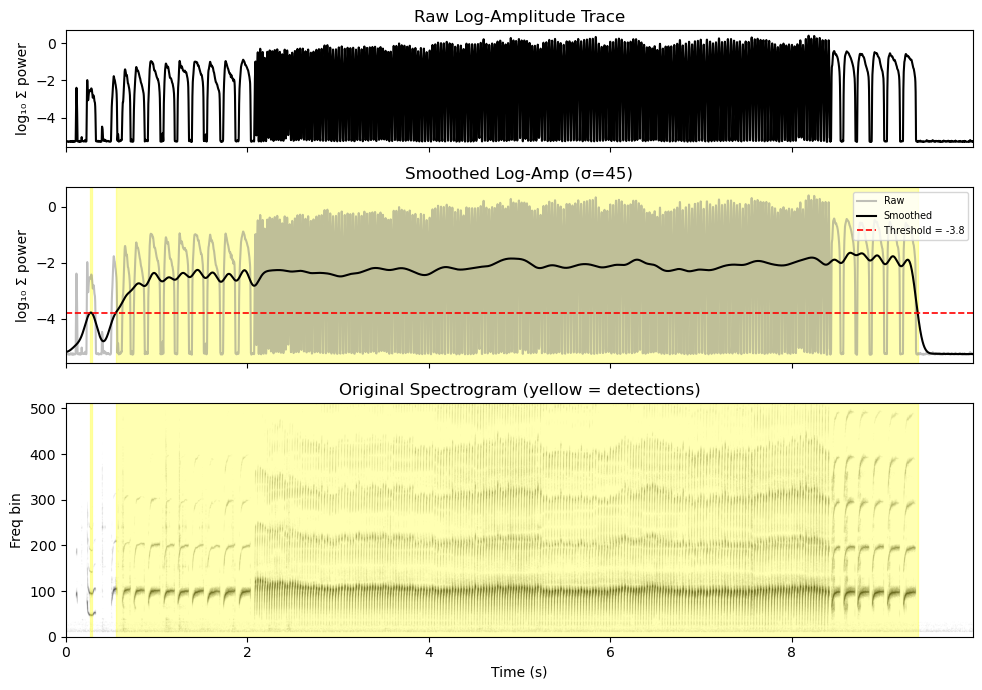


Detected intervals (s):
    0.264 –   0.287
    0.548 –   9.391


In [15]:
#!/usr/bin/env python
# -*- coding: utf‑8 -*-
"""
Visualise a spectrogram stored in an .npz file and detect song by applying
smoothing + threshold directly to the log‑amplitude trace.

Required .npz keys
    s : 2‑D ndarray  (freq × time)           spectrogram values
Optional keys
    f : 1‑D ndarray  frequency axis (Hz)
    t : 1‑D ndarray  time axis (s)

If 't' is missing, supply `segment_duration` so the code can build a time axis.
"""

from pathlib import Path
from typing import Union, List, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ── helper: build intervals from a boolean mask ─────────────────────────────
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray) -> List[Tuple[float, float]]:
    spans: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, flag in enumerate(mask):
        if flag and not in_run:
            in_run, start = True, times[idx]
        elif not flag and in_run:
            spans.append((start, times[idx]));  in_run = False
    if in_run:
        spans.append((start, times[-1]))
    return spans

# ── main routine ────────────────────────────────────────────────────────────
def plot_npz_logamp_panels(
        npz_path: Union[str, Path],
        segment_duration: Optional[float] = None,  # deduced from 't' if present
        smoothing_sigma: float = 3,
        log_threshold: float = -1.0,
    ) -> List[Tuple[float, float]]:
    """Generate 3 synced panels and return detected (start, end) intervals."""
    npz_path = Path(npz_path).expanduser()
    if npz_path.suffix.lower() != ".npz":
        raise ValueError("Only .npz files are supported.")

    # ── load data ──────────────────────────────────────────────────────────
    with np.load(npz_path, allow_pickle=True) as npz:
        S_raw = npz["s"]
        f = npz["f"] if "f" in npz.files else np.arange(S_raw.shape[0])
        t = npz["t"] if "t" in npz.files else None

    # Derive / validate time axis
    if t is None:
        if segment_duration is None:
            raise ValueError("Provide segment_duration if 't' axis is absent.")
        n_times = S_raw.shape[1]
        t = np.linspace(0, segment_duration, n_times, endpoint=False)
    else:
        if segment_duration is None:
            segment_duration = t[-1] + (t[1] - t[0])

    # Convert dB → linear if needed
    eps = np.finfo(float).eps
    S_lin = 10 ** (S_raw / 10) if np.any(S_raw < 0) else S_raw

    # ── log‑amplitude trace & smoothing ───────────────────────────────────
    log_amp    = np.log10(S_lin.sum(axis=0) + eps)
    log_amp_sm = gaussian_filter1d(log_amp, sigma=smoothing_sigma)
    detections = log_amp_sm > log_threshold
    det_intervals = mask_to_intervals(detections, t)

    # ── plotting (3 panels) ───────────────────────────────────────────────
    fig, axs = plt.subplots(
        3, 1, figsize=(10, 7), sharex=True,
        gridspec_kw=dict(height_ratios=[1, 1.5, 2])
    )

    # 1) raw log‑amp
    axs[0].plot(t, log_amp, color="black")
    axs[0].set_ylabel("log₁₀ Σ power")
    axs[0].set_title("Raw Log‑Amplitude Trace")

    # 2) smoothed log‑amp with threshold
    axs[1].plot(t, log_amp,    color="grey", alpha=0.5, label="Raw")
    axs[1].plot(t, log_amp_sm, color="black",            label="Smoothed")
    axs[1].axhline(log_threshold, color="red", ls="--", lw=1.2,
                   label=f"Threshold = {log_threshold}")
    for s_int, e_int in det_intervals:
        axs[1].axvspan(s_int, e_int, color="yellow", alpha=0.3)
    axs[1].set_ylabel("log₁₀ Σ power")
    axs[1].set_title(f"Smoothed Log‑Amp (σ={smoothing_sigma})")
    axs[1].legend(fontsize="x-small", loc="upper right")

    # 3) original spectrogram
    S_norm = (S_raw - S_raw.min()) / (S_raw.max() - S_raw.min() + eps)
    axs[2].imshow(
        S_norm, origin="lower", aspect="auto",
        extent=[t[0], t[-1], f[0], f[-1]],
        cmap="binary"
    )
    for s_int, e_int in det_intervals:
        axs[2].axvspan(s_int, e_int, color="yellow", alpha=0.3)
    axs[2].set_ylabel("Freq bin")
    axs[2].set_xlabel("Time (s)")
    axs[2].set_title("Original Spectrogram (yellow = detections)")

    plt.tight_layout()
    plt.show()

    # console report
    if det_intervals:
        print("\nDetected intervals (s):")
        for s_int, e_int in det_intervals:
            print(f"  {s_int:7.3f} – {e_int:7.3f}")
    else:
        print("\nNo detections above threshold.")
    return det_intervals

# ── example call ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    plot_npz_logamp_panels(
        "/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/train/llb3_0010_2018_04_23_15_03_45_segment_0.npz",
        segment_duration=10,     # supply if 't' axis missing in file
        smoothing_sigma=45,       # Gaussian σ (samples)
        log_threshold=-3.8        # dB value after smoothing
    )
